# MLP Classifier

An MLPClassifier is a type of feedforward neural network, and is said to be a powerful tool for tackling imbalanced datasets. It has a strong ability to learn complex patterns and nonlinear relationships in data so will hopefully be able to dishtinguish between churners and those who will remain with the bank. By adjusting hyperparameters and proability thresholds along with a few other methods we should hopefully be able to build a MLPClassifier that prioritises predicting a churn in order for the bank to keep its customers.

## Importing some libraries we will use

In [4]:
import sys
sys.path.append('..')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from helper_fun import *
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier


## Importing our data and the different splits we have created

In [6]:
# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

Check our data is of the right size

In [7]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((8000, 13), (8000,), (2000, 13), (2000,))

Import the 4 different splits we have created from the train_raw which we will use to build the model to then do a final test on test_raw with the hope recreating a competition scenario

In [8]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

These are the splits we have

In [9]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Creating our initial model

For our initial model we will use a fairly standard neural network design, with 2 hidden layers, one with 32 nodes the next with 16. We only have 13 features so I didn't want the model to be too complicated and I was also wary of the model taking too long to train on my laptop. This didn't prove too much of an issue apart from hyper-parameter tuning which we will get to later.

In [10]:
# Define the model
model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

In helper_fun we have created a function that will help us evaluate the performance of our different splits using a variety of different metrics.

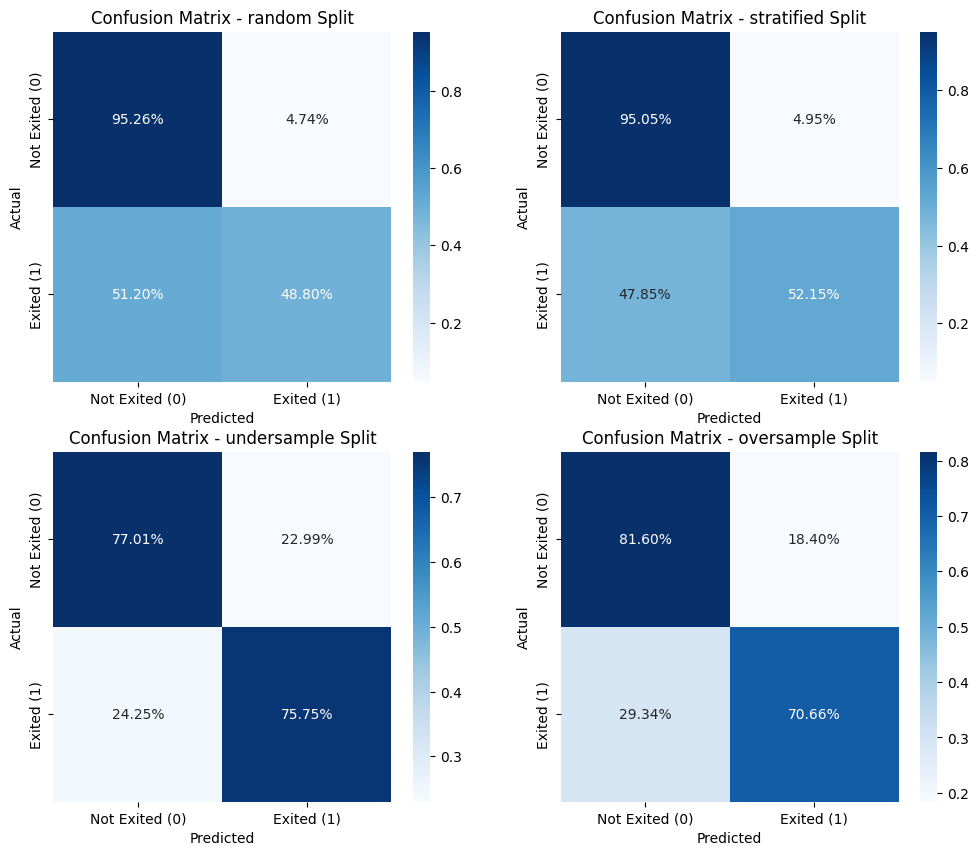

<Figure size 800x600 with 0 Axes>

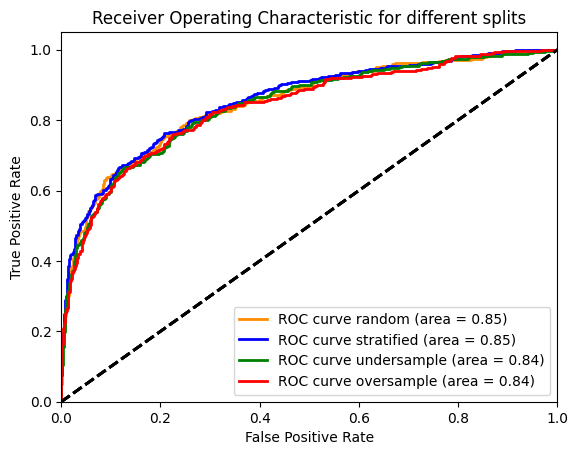

In [11]:
performance_df = evaluating_performance_diff_splits(model, split_data, key_metric_only=True)  

The ROC curves indicate a fairly good performance on all four of our splits, the confusion matrices give a less convincing story, lets take a look at the rest of the metrics before we comment further.

In [12]:
performance_df

,recall,f1-score,balalanced_MCC
random,0.488024,0.585278,0.497590
stratified,0.521472,0.608229,0.522571
undersample,0.757485,0.576310,0.527669
oversample,0.706587,0.587796,0.525696


## Parameter Tuning

### Random Search

Before we proceed further I want to see if I can get a little bit more performance out of the model by picking better parameters, I won't spend too much time doing this now though and will simply start by using a random search with 5 fold cross validation to see if we can find better parameters for a 2 layer MLP. I could of also chosen to use I grid search here but I wasn't totally sure on the parameter distribution to include in my grid, so I thought a random search would give me results a a wider range of parameters.

I will look to maximise the f1_score as I belive this is a good metric to indicate a good overal performance on our imbalanced data. I will perfom the tuning on the whole of the X_train_raw and y_train_raw.

In [13]:
# Define a scorer for F1-score (or any metric of choice)
f1_scorer = make_scorer(f1_score, pos_label=1)

This is the code I used for my gridsearch, I won't run it in this file but I have saved the parameters in a pickle so we can look at the performance using them.

```python
# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(randint(3, 128).rvs(), randint(3, 128).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=1, random_state=42)

# Fit the random search to the data
random_search.fit(X_train_raw, y_train_raw)
print("Done")
```

In [14]:
# Load the parameters from the pickle file
with open('random_params.pkl', 'rb') as file:
    random_params = pickle.load(file)

best_params_random = random_params['best_params']
best_score_random = random_params['best_score']
# Display the best parameters
print(f"Best parameters: {best_params_random}"+f"\nBest score: {best_score_random}")

Best parameters: {'activation': 'relu', 'alpha': 0.009467299887367345, 'hidden_layer_sizes': (60, 22), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.5956830838444812


Create a model with these parameters

In [15]:
model_RS = MLPClassifier(**best_params_random, max_iter=1000, random_state=42)

Look at our 3 important metrics for our model with parameters from our random search.

In [16]:
performance_RS_df = evaluating_performance_diff_splits(model_RS, split_data,display_confusion=False,display_roc=False, key_metric_only=True)
performance_RS_df

,recall,f1-score,balalanced_MCC
random,0.473054,0.578755,0.491938
stratified,0.524540,0.619565,0.533825
undersample,0.766467,0.566999,0.519280
oversample,0.688623,0.575000,0.506177


Using these new parameters has seemed to decrease our model performance on each of our four splits, recall has gone down for random and oversampled, stayed the same more or less for stratified, with minor improvements on the undersampled split. For F1-score there has been a slight decrease for all but stratified where it has risen by 0.01. Balanced MCC has also suffered similar performance decrease.

### Optuna

As the random search hasn't given us the results we have hoped for we will look at another method for fine-tuning our parameters.

Optuna is a hyperparameter optimization framework that can auto finding the best combination of hyperparameters for a machine learning model. It works by defining a search space much like a random search and then systematically exploring this space algorithms like Tree-structured Parzen Estimator (TPE) to find the optimal configuration of our parameters.

Run the command,
```python
!pip install optuna
```
if it is not installed already.

Again we won't run the code here as it takes quite a long time but will show the parameters we got from it. This is the objective function and study I was running,

```python
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_units_layer1 = trial.suggest_int('n_units_layer1', 10, 200)
    n_units_layer2 = trial.suggest_int('n_units_layer2', 10, 200)   
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1,log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    
    hidden_layer_sizes = (n_units_layer1, n_units_layer2)
    # Create the model with suggested hyperparameters
    model_optuna = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=1000,
        random_state=42
    )
    
    # Evaluate the model using cross-validation
    score = cross_val_score(model_optuna, X_train_raw, y_train_raw, cv=5, scoring=f1_scorer).mean()
    
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, timeout=120)
```



In [17]:
# Load the parameters from the pickle file
with open('optuna_params.pkl', 'rb') as file:
    optuna_params = pickle.load(file)

best_params_optuna = optuna_params['best_params']
best_score_optuna = optuna_params['best_score']
# Display the best parameters
print(f"Best parameters: {best_params_optuna}"+f"\nBest score: {best_score_optuna}")

Best parameters: {'activation': 'relu', 'solver': 'adam', 'alpha': 0.021121340425575865, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (85, 38)}
Best score: 0.6058285910201333


Define a new MLPClassifier with these parameters.

In [18]:
# Define a new model with the best parameters
model_optuna = MLPClassifier(**best_params_optuna, max_iter=1000, random_state=42)

In [19]:
performance_optuna_df = evaluating_performance_diff_splits(model_optuna, split_data, display_confusion=False, display_roc=False, key_metric_only=True)

In [20]:
performance_optuna_df

,recall,f1-score,balalanced_MCC
random,0.467066,0.583178,0.497415
stratified,0.503067,0.602941,0.517199
undersample,0.751497,0.583721,0.534539
oversample,0.667665,0.579221,0.506281


Even though the performance metrics are worse, than our initial model, I'm opting to use the parameters from Optuna since they were fine-tuned using 5-fold cross-validation. This should help the model generalize better on unseen data, improving its robustness.

## Feature Importance

In this step, we aim to eliminate features that the model finds less important for predicting churn. By doing so, we can reduce overfitting and minimize noise, leading to a more streamlined and effective model.

Permutation feature importance measures the impact of randomly shuffling each feature on the model's performance. This approach helps identify how crucial each feature is for accurate predictions by observing the changes in performance after shuffling each feature.

In [21]:
X_train_random, X_val_random, y_train_random, y_val_random = split_data['random']
model_optuna.fit(X_train_random, y_train_random)
# Calculate permutation importance
perm_importance = permutation_importance(model_optuna, X_val_random, y_val_random, n_repeats=500, random_state=42, n_jobs=-1)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test_raw.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
11        Gender_Female    0.067259
3         NumOfProducts    0.059806
1                   Age    0.057489
12          Gender_Male    0.050939
7        IsActiveMember    0.027507
2               Balance    0.020792
9     Geography_Germany    0.020319
8      Geography_France    0.020160
10      Geography_Spain    0.014681
6   CreditScoreGivenAge    0.008042
5           TenureByAge    0.004694
0           CreditScore    0.002476
4    BalanceSalaryRatio   -0.000265


From this we see that almost all the features have some positive effects on the model performance, with the exception of BalanceSalaryRatio. We will take the top 6 features and construct a model only using them.

In [22]:
top_6_features = feature_importance_df.head(6)
top_6_feature_indices = [X_test_raw.columns.get_loc(feature) for feature in top_6_features['Feature']]
print(top_6_feature_indices)

[11, 3, 1, 12, 7, 2]


Here we adjust the different splits to contain only are top 6 most important features.

In [23]:
# Filter the splits to retain only the top 6 features
split_data_6 = {}
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    split_data_6[split] = (
        X_train.iloc[:, top_6_feature_indices],
        X_val.iloc[:, top_6_feature_indices],
        y_train,
        y_val
    )

# Verify the changes
for split in split_data_6:
    X_train, X_val, y_train, y_val = split_data_6[split]
    print(f"{split} split - X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

random split - X_train shape: (6400, 6), X_val shape: (1600, 6)
stratified split - X_train shape: (6400, 6), X_val shape: (1600, 6)
undersample split - X_train shape: (2594, 6), X_val shape: (1600, 6)
oversample split - X_train shape: (10206, 6), X_val shape: (1600, 6)


In [24]:
performance_optuna_df_top6 = evaluating_performance_diff_splits(model_optuna, split_data_6, display_confusion=False, display_roc=False, key_metric_only=True)
performance_optuna_df_top6

,recall,f1-score,balalanced_MCC
random,0.410180,0.539370,0.460039
stratified,0.515337,0.597865,0.512031
undersample,0.727545,0.552273,0.488476
oversample,0.709581,0.580882,0.518498


The splits with less features shows slightly better recall for the stratified method and a drop in F1-score and balanced MCC for undersampling and oversampling methods. However, the overall trend remains consistent, with undersampling generally providing the highest recall but varied performance on other metrics.

I'm tempted by the drop in time it takes to run the model to use less features, but I'm slightly concerned this will cause the model to be less generalisable so for now I'm gonna proceed with all 12 features.

## 2D representation and SMOTE

Over and Under sampling have been giving us good performance so far, but if I'm to proceed with using them to train my final model then I want to minimise some of the drawbacks from using them. Undersampling loses us a lot of data that could be valuable for predictions and over-sampling could leave us prone to overfitting. I'm gonna try use a combination of oversampling using SMOTE and undersampling to try give us a balanced dataset that has no duplicates and is closer in size to the original set of seen data we have.

SMOTE generates synthetic samples for the positive class to balance imbalanced datasets. By creating new varied data points SMOTE improves the model's ability to learn from the positive class, improving overall performance and reducing bias.

Using SMOTE and undersampling together is proposed here https://arxiv.org/abs/1106.1813

We will first use PCA to visualize our data in 2D.

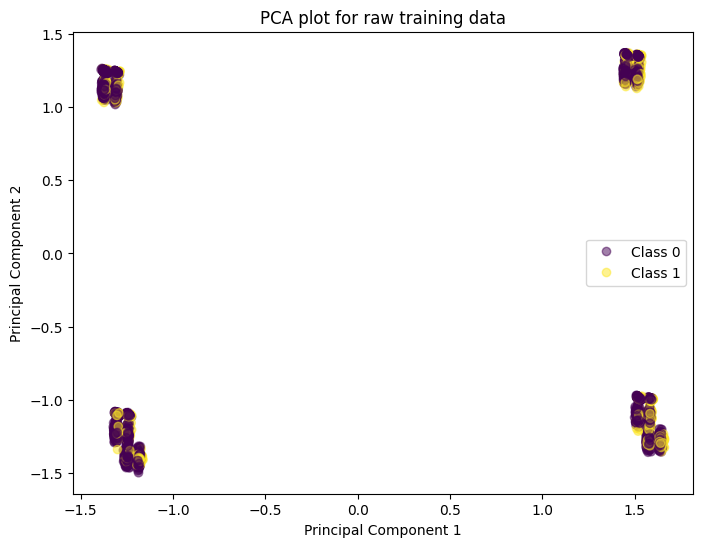

In [25]:
# Function to plot PCA
def plot_pca_2d(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
    plt.show()

plot_pca_2d(X_train_random, y_train_random, 'PCA plot for raw training data')

We will now over and under sample our data.

In [26]:
over = SMOTE(sampling_strategy=0.35) #oversamples to make minority class 30%
under = RandomUnderSampler(sampling_strategy=0.5) #undersamples to make majority class 50%
X_resampled, y_resampled = over.fit_resample(X_train_random, y_train_random)
X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)
print(f"Resampled X shape: {X_resampled.shape}")
print(f"Resampled y shape: {y_resampled.shape}")

Resampled X shape: (5358, 13)
Resampled y shape: (5358,)


We can see are dataset is much bigger than it is when we use undersampling by itself, but unlike oversampling will have no duplicates.

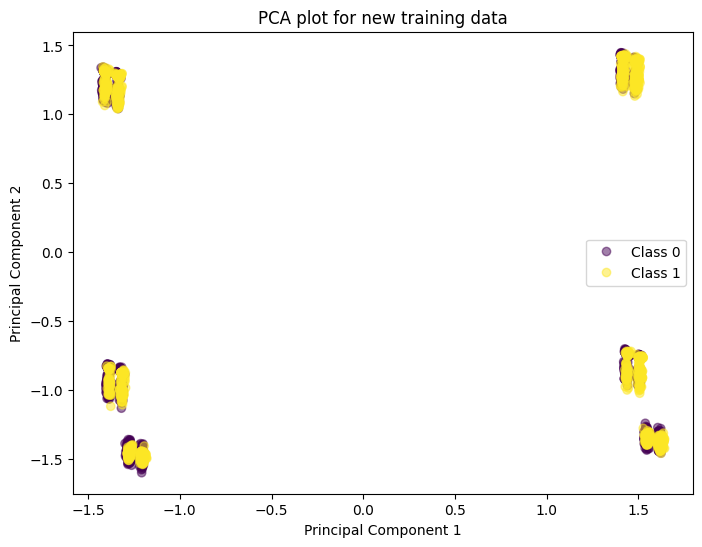

In [27]:
plot_pca_2d(X_resampled, y_resampled, 'PCA plot for new training data')

We can see it mantains a similar 2D representation to the random training data which is reassuring. We will now test the performance of the model using this split.

In [28]:
smote_under_split = {'SMOTE_under': (X_resampled, X_val_random, y_resampled, y_val_random)}
performance_SMOTE_under_df = evaluating_performance_diff_splits(model_optuna, smote_under_split, display_confusion=False, display_roc=False, key_metric_only=True)
performance_SMOTE_under_df

,recall,f1-score,balalanced_MCC
SMOTE_under,0.610778,0.608955,0.528421


In comparison to the random split this has increased recall, but decreased f1-score and balanced MCC. It is also not performing near as well as undersampling so seems little point in using this. This poor performance could possibly be due to the fact that the synthetic data doesn' accurately capture the relationship between features.

## Probability threshold

Our main issue is clearly a lower recall than we would like for the positive class, to try to increase this I'm gonna try adjust the probability threshold in a way to increase our recall but not sacrifice too much precision. I will do this using the ROC curve and choose the threshold that corresponds to the point closest to the top left, which will give us a high sensitivity, while keeping specicivity at an appropriate level hopefully.

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

I'm gonna work with the model parameters I've got from optuna even though right now the metrics don't look as good as the initial model, but as the parameters were chosen using k-fold cross-validation my thinking is that they will generalise better to the unseen data. I will also start off by just focusing on doing this for the stratified split.

In [29]:
X_train_strat, X_val_strat, y_train_strat, y_val_strat = split_data['stratified']

In [30]:
model_optuna.fit(X_train_strat, y_train_strat)
y_prob = model_optuna.predict_proba(X_val_strat)[:, 1]

As detailed in the blog post above, we can find this optimal threshold using Youden's J statistic

J = Sensitivity + Specisivity - 1

Which is equivalent to,

J = TPR - FPR

we will look for the threshold that maximises J.

In [31]:
fpr, tpr, thresholds = roc_curve(y_val_strat, y_prob)
threshold_05_index = np.where(thresholds <= 0.5)[0][0]
print(f"Index for threshold 0.5: {threshold_05_index}")
J= tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print(f"Best threshold: {best_threshold}")

Index for threshold 0.5: 71
Best threshold: 0.25520605596780455


This threshold is considerably lower than the standard 0.5, lets also visulaise this on the ROC curve.

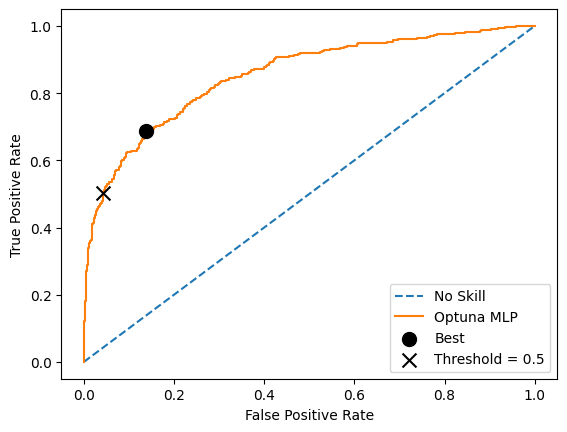

In [32]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Optuna MLP')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100,zorder=5)
plt.scatter(fpr[threshold_05_index], tpr[threshold_05_index], marker='x', color='black', label='Threshold = 0.5', s=100, zorder=5)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Now let's look at the performance metrics using this threshold on our stratified split.

In [33]:
y_val_pred = (y_prob> best_threshold).astype(int)

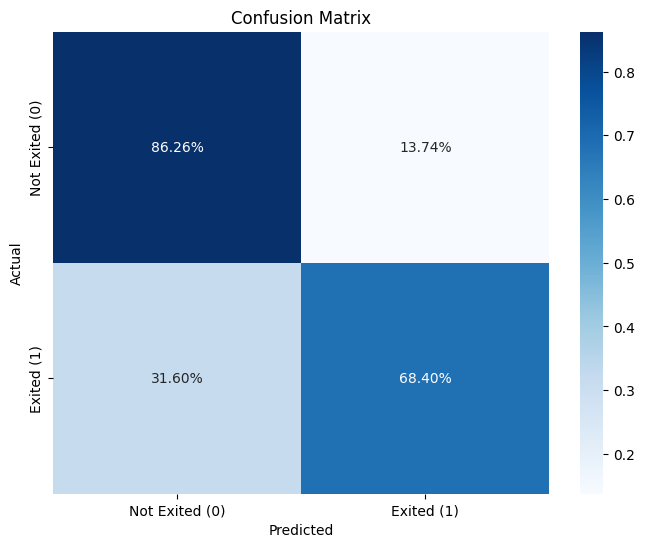

,recall,f1-score,balalanced_MCC
Raw split,0.684049,0.616022,0.555619


In [34]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val_strat, y_val_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate classification report
report = classification_report(y_val_strat, y_val_pred)
# Extract metrics from classification report
report_dict = classification_report(y_val_strat, y_val_pred, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_val_strat, y_val_pred)

performance_best_thresh = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

performance_best_thresh_df = pd.DataFrame(performance_best_thresh, index=['Raw split'])
performance_best_thresh_df


These metrics are much more encouraging, the balanced MCC is still not maybe as high as you would like, but our recall is improved from 0.52 initially to 0.68 and we are keeping our false positives low enough to avoid wasting too many resources. It is also a positive that we are getting good results on a stratified split as this should gneralise well to unseen data as both the training and validation sets maintain the class distribution of our seen data, so it should provide a representitive evaluation of the models performance, 

## Bagging

To further imrpove the generalization of my model I'm going to perform bagging, this will help reduce the variance of my predictions and is also a good ensemble method to use with imbalanced data.

Info on bagging here

I will perform bagging on my MLP classifier with the parameters from optuna and then similar to above will adjust the probability threshold afterwards.

In [35]:
# Initialize the BaggingClassifier with the model_optuna
bagging_model = BaggingClassifier(estimator=model_optuna, n_estimators=50, random_state=42, n_jobs=-1)

# Fit the bagging model on the stratified training data
bagging_model.fit(X_train_strat, y_train_strat)

y_prob_bag = bagging_model.predict_proba(X_val_strat)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_strat, y_prob_bag)
J= tpr - fpr
ix = np.argmax(J)
best_threshold_bag = thresholds[ix]

y_val_pred_bag = (y_prob_bag> best_threshold_bag).astype(int)

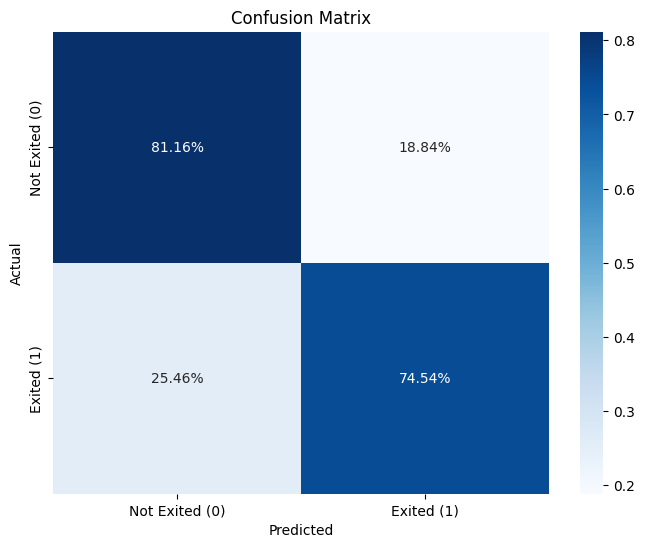

,recall,f1-score,balalanced_MCC
stratified split with bagging,0.745399,0.600742,0.558241


In [36]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_val_strat, y_val_pred_bag)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate classification report
report = classification_report(y_val_strat, y_val_pred_bag)
# Extract metrics from classification report
report_dict = classification_report(y_val_strat, y_val_pred_bag, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_val_strat, y_val_pred_bag)

performance_bagging = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

performance_bagging_df = pd.DataFrame(performance_bagging, index=['stratified split with bagging'])
performance_bagging_df

This has improved our recall even more with it now at 0.745 from 0.684, we have sacrificed a bit of an increase in the false negatives, but I think this is our best MLPClassifier we have made so far. It should hopefully generalise well due to the bagging and as we have designed it using the stratified split the metrics should carry over to the unseen data. 

I'm going to proceed with this bagged model with the optuna parameters as my final model.

## Final model

I will use the bagged model we just created as my final model, so now I will train it on all our seen data and then test on all the unseen hopefully as I designed the model on a stratified split the performance metrics should stay at a similar level even on the unseen data.

In [37]:
# Initialize the BaggingClassifier with the model_optuna
bagging_model = BaggingClassifier(estimator=model_optuna, n_estimators=50, random_state=42, n_jobs=-1)

# Fit the bagging model on the stratified training data
bagging_model.fit(X_train_raw, y_train_raw)

y_prob = bagging_model.predict_proba(X_test_raw)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_raw, y_prob)
J= tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

y_test_pred = (y_prob> best_threshold).astype(int)

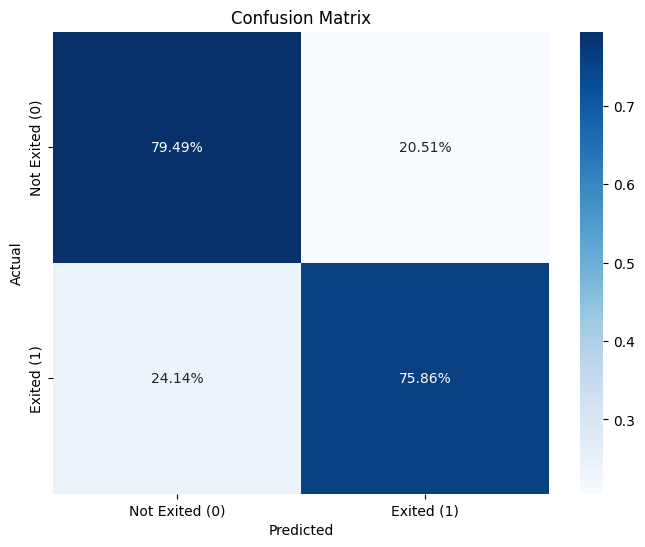

,recall,f1-score,balalanced_MCC
FINAL TEST,0.758621,0.591739,0.55384


In [38]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Not Exited (0)', 'Exited (1)'],
            yticklabels=['Not Exited (0)', 'Exited (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Generate classification report
report = classification_report(y_test_raw, y_test_pred)
# Extract metrics from classification report
report_dict = classification_report(y_test_raw, y_test_pred, output_dict=True)
balanced_MCC = balanced_MCC_macro_avg(y_test_raw, y_test_pred)

performance_bagging = {
                'recall' : report_dict['1']['recall'],
                'f1-score' : report_dict['1']['f1-score'],
                'balalanced_MCC' : balanced_MCC
            }

performance_bagging_df = pd.DataFrame(performance_bagging, index=['FINAL TEST'])
performance_bagging_df

I'm fairly happy with this as a final result for my model. The performance on the unseen data is pretty good the recall of 75.86% is strong, the f1-score and bal MCC seem consistent with what we have seen from lots of the other models made in this file. The False positives are maybe a bit too high as this could lead to the bank wasting resources on customers who aren't planning on leaving.

## Conclusion and model discussion

In conclusion, this project successfully developed and implemented a Bagged MLPClassifier model to predict customer churn. By employing a combination of techniques, including Optuna for hyperparameter optimization, adjusting the probability threshold for improved decision-making, and bagging to enhance model robustness, the model achieved a strong recall of 75.86%. This indicates the model’s ability to correctly identify a significant portion of customers who will churn. This predictive model can be a valuable tool for banks to proactively intervene and implement targeted retention strategies.

However, it's important to acknowledge the limitations of using an MLPClassifier. Training neural networks can be computationally expensive and time-consuming, sticking to a more simple network acritecture could be a way to minimise this but likely at some performance cost. Additionally, MLP classifiers can be prone to overfitting, requiring careful regularization and hyperparameter tuning, as we used only two layers I think the risk of overfitting was not too high, and our model did seem to generalise fairly well. The complex nature of neural networks can also make it difficult to interpret the model's decision-making process.

The success of the Bagged MLPClassifier model can be attributed to its ability to capture complex, non-linear relationships within the data. By bagging the MLP classifiers, the model effectively reduces variance and improves generalization. The incorporation of Optuna further enhanced the model's performance by optimizing hyperparameters, and suggested us to use a model that contained a much larger amount of nodes than our original model.

From our metrics we can see that while overall this is not the strongest model, as shown by the Balanced MCC, which for a perfect model would be 1. It does serve as a pretty good predictor of customer churns. More data and more features would be hugely beneficial for this model, and would further enhance the predictive power.

## References

https://arxiv.org/abs/1106.1813

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

https://github.com/optuna/optuna

Github Copilot was used for writing portions of this code